<a href="https://colab.research.google.com/github/lynxoo/ue-wroc-sad/blob/master/SAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statystyczna Analiza Danych
## Analiza Szkockich Whisky

Autorzy projektu:
* Łukasz Fąfara
* Artur Malarz

## Wstęp

Celem projektu jest przeprowadzenie klasteryzacji oraz analizy wybranych danych statystycznych. Przedmiotem badań poniższej analizy będzie zbiór ocen szkockiej whisky pozyskany z serwisu [Keggle](https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews) \(serwis danych źródłowych [Whisky Advocate](http://whiskyadvocate.com/)).

Zbiór zawiera następujące informacje na temat produktu:
- numer porządkowy
- nazwę
- kategorię
- średnią ocen jakości whisky (smaku) wystawioną przez recenzentów
- cenę jednostkową
- opis

Średnią ocenę jakości whisky serwis klasyfikuje następująco:
95-100 points—Classic: a great whisky  
90-94 points—Outstanding: a whisky of superior character and style  
85-89 points—Very good: a whisky with special qualities  
80-84 points—Good: a solid, well-made whisky  
75-79—Mediocre: a drinkable whisky that may have minor flaws  
50-74—Not recommended  

Większość rekordów zawiera także informacje na temat wieku danej whisky (czasu leżakowania) oraz zawartości alkoholu.

Dokonując analizy statystycznej zebranych danych, chcielibyśmy sprawdzić, czy whisky dostępne na rynku można skategoryzować względem jakości, ceny oraz zawartości alkoholu. Chcielibyśmy sprawdzić, które z tych parametrów mają na siebie wpływ, a także czy wiek whisky jest jego największą zaletą, która jednogłośnie dyktuje jego smak oraz cenę.

### Wstępna obróbka danych

W tym etapie dane zostaną wczytane, pozbawione nieistotnych kolumn, a te które pozostaną, zostaną poddane korekcji typu. Przy wykorzystaniu kolumny `name` zostaną wyodrębnione kolumny takie jak `abv`, mówiąca o zawartości alkoholu oraz `age` zawierająca czas leżakowania danego trunku.

In [0]:
import pandas as pd
scotch = pd.read_csv(r'https://github.com/lynxoo/ue-wroc-sad/raw/master/scotch_review.csv')

In [137]:
scotch.head(5)

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


#### Usunięcie nadmiarowych kolumn

Nienazwana kolumna z numerem porządkowym (`Unnamed: 0`), kategorią (`category`) oraz opisem (`description`) są nieistotne na potrzeby poniższej analizy. Cena każdego z produktów została podana w dolarach, więc konwersja waluty jest niepotrzebna a sama jej kolumna (`currency`) może zostać usunięta. 

In [138]:
scotch.drop(['Unnamed: 0', 'category', 'currency', 'description'], axis=1, inplace=True)
scotch.head(5)

,name,review.point,price
0,"Johnnie Walker Blue Label, 40%",97,225
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,4500.00
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,13500.00
3,"Compass Box The General, 53.4%",96,325
4,"Chivas Regal Ultis, 40%",96,160


#### Korekcja typów

Weryfikacja czy każda z kolumn zawiera oczekiwany typ danych.

In [139]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2247 non-null   object
 1   review.point  2247 non-null   int64 
 2   price         2247 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.8+ KB


Kolumna odpowiedzialna za cenę produktu (`price`) jest typu `object` oraz musi zostać przekonwertowana na typ `float` ze względu na możliwość wystąpienia wartości cząstkowych (centów).

In [140]:
def parse_price(text):
  try:
    return float(text)
  except:
    pass
  return None
scotch['price'] = [parse_price(price) for price in scotch['price']]
scotch['price'].isnull().value_counts()

False    2228
True       19
Name: price, dtype: int64

Po konwersji typu, zostało 19 rekordów, które miały niepoprawną wartość liczbową oraz zostały opisane wartością `None`. Zostaną one usunięte ze zbioru.

In [141]:
scotch.dropna(inplace=True)
scotch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2228 entries, 0 to 2246
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2228 non-null   object 
 1   review.point  2228 non-null   int64  
 2   price         2228 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 69.6+ KB


### Ekstrakcja dodatkowych informacji

W tym kroku, z kolumny `name` wyciągnięte zostaną informacje dotyczące zawartości alkoholu (docelowa kolumna `abv` - _alcohol by volume_) oraz wieku, czyli czasu leżakowania whisky (docelowa kolumna `age`).

#### Ekstrakcja kolumny `age`

Wiek alkoholu opisywany jest frazą `X years old`, która w zależności od przypadku może prezentować różne formy. Do wydobycia tej informacji wykorzystane zostanie wyrażenie regularne o następującym wzorcu `(\d+) years? old`. Jeśli dany rekord nie będzie zawierał informacji o szukanej cesze, jej wartość zostanie ustawiona na `None`.

In [0]:
import re
def parse_age(text):
  matches = re.search('(\d+) years? old', text, re.IGNORECASE)
  return int(matches.group(1)) if matches else None

scotch['age'] = [parse_age(text_age) for text_age in scotch['name']]

In [143]:
scotch.isnull().sum()

name               0
review.point       0
price              0
age             1028
dtype: int64

W wyniku ekstrakcji, pojawiły się rekordy niezawierające informacji na temat wieku alkoholu. Stanowią one znaczną część zbioru, jednak nie pasują do założeń, a rozmiar pozostałej liczby rekordów pozwala na dalszą analizę.

In [0]:
scotch.dropna(inplace=True)

#### Ekstrakcja kolumny `abv`

Zawartość alkoholu zawarta została w nazwie produktu oraz zawiera następujący format `X%`. Do wydobycia tej informacji wykorzystane zostanie wyrażenie regularne o następującym wzorcu `([\d.]+)%`. Jeśli dany rekord nie będzie zawierał informacji o szukanej cesze, jej wartość zostanie ustawiona na `None` w innym wypadku zostawiamy jedynie wartość liczbową (bez znaku %).


In [0]:
import re
def parse_alcohol(text):
  matches = re.search(r"([\d.]+)%", str(text))
  return float(matches.group(1)) if matches else None

scotch['abv'] = [parse_alcohol(name) for name in scotch['name']]

In [146]:
scotch.isnull().sum()

name            0
review.point    0
price           0
age             0
abv             7
dtype: int64

W wyniku ekstrakcji pojawiło się kilka rekordów, które nie zawierały szukanej informacji - pozbywamy się ich.

In [0]:
scotch.dropna(inplace=True)

### Weryfikacja danych


In [150]:
scotch.describe()

,review.point,price,age,abv
count,1193.000000,1193.000000,1193.000000,1193.000000
mean,86.612741,429.583403,20.723386,48.027150
std,4.183409,1715.623951,9.857403,5.954231
min,63.000000,13.000000,3.000000,40.000000
25%,84.000000,75.000000,13.000000,43.000000
50%,87.000000,120.000000,18.000000,46.000000
75%,90.000000,225.000000,26.000000,52.700000
max,97.000000,27620.000000,70.000000,67.400000


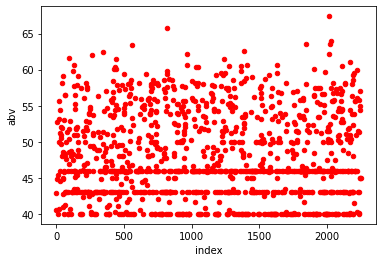

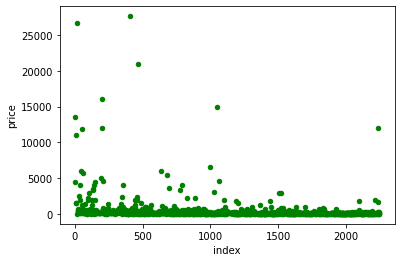

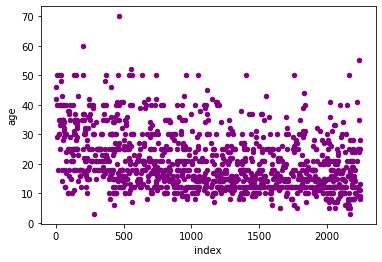

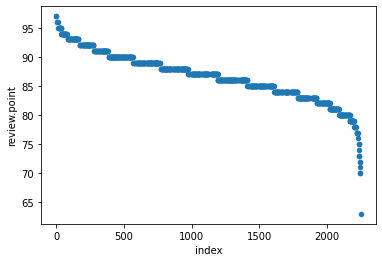

In [107]:
scotch.reset_index().plot.scatter(x='index', y='abv', color='red')
scotch.reset_index().plot.scatter(x='index', y='price', color='green')
scotch.reset_index().plot.scatter(x='index', y='age', color='purple')
scotch.reset_index().plot.scatter(x='index', y='review.point')

Na powyższych zestawieniach można zauważyć, że część danych odstaje znacznie od reszty. Wśród takich danych znajduje się na przykład bardzo wysoka cena sięgająca ponad 27000, gdzie średnia wartość nie przekracza 500, a mediana  1200. Usuwamy ze zbioru odstające dane.

#### Usuwanie odstających danych

Do wyznaczenia niepożądanych danych wykorzystamy wykres pudełkowy. Wszystkie wartości leżące poza wąsami o długości 4 IQR (rozstęp ćwiartkowy) uznajemy za odstające, a następnie usuwamy je z ramki danych.

Wyznaczamy pierwszy kwartyl, trzeci kwartyl i rozstęp ćwiartkowy.

In [108]:
q1 = scotch.quantile(0.25)
q3 = scotch.quantile(0.75)
 
iqr = q3 - q1
iqr

review.point      6.0
price           150.0
age              13.0
abv               9.7
dtype: float64

In [109]:
outliers = (scotch < (q1 - 4.0 * iqr)) | (scotch > (q3 + 4.0 * iqr))
outliers.sum()

abv              0
age              0
name             0
price           79
review.point     0
dtype: int64

In [110]:
scotch[outliers.any(1)]

,name,review.point,price,age,abv
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,4500.0,42.0,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,13500.0,46.0,42.9
7,"Bowmore, 40 year old, 44.8%",96,11000.0,40.0,44.8
8,"The Dalmore, 50 year old, 52.8%",96,1500.0,50.0,52.8
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",96,1500.0,29.0,45.4
...,...,...,...,...,...
1831,"Glenglassaugh, 44 year old, 1960 vintage, 41.7%",83,900.0,44.0,41.7
2094,"BenRiach 40 year old, 50%",80,1800.0,40.0,50.0
2218,"Auchentoshan 1962, 41 year old, 40.3%",77,2000.0,41.0,40.3
2236,"The Macallan Lalique Decanter, 55 year old, 40.1%",74,12000.0,55.0,40.1


In [112]:
no_outliers = ~(outliers).any(axis=1)

scotch._update_inplace(scotch[no_outliers])
scotch.describe()

,review.point,price,age,abv
count,1114.000000,1114.000000,1114.000000,1114.000000
mean,86.395871,162.806104,19.412926,48.052145
std,4.063780,145.558497,8.533326,5.999513
min,63.000000,13.000000,3.000000,40.000000
25%,84.000000,70.000000,12.000000,43.000000
50%,87.000000,111.000000,18.000000,46.000000
75%,89.000000,190.000000,25.000000,52.875000
max,95.000000,824.000000,50.000000,67.400000


## Rozkład wartości

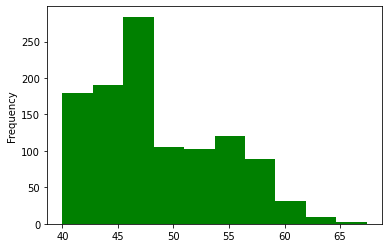

In [113]:
scotch['abv'].plot.hist(color='green')

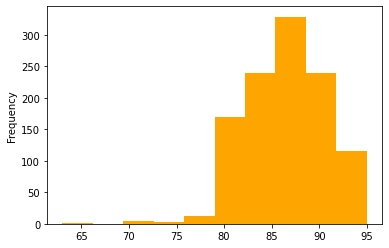

In [114]:
scotch['review.point'].plot.hist(color='orange')

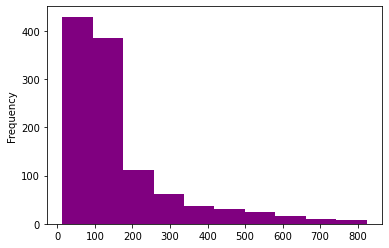

In [115]:
scotch['price'].plot.hist(color='purple')

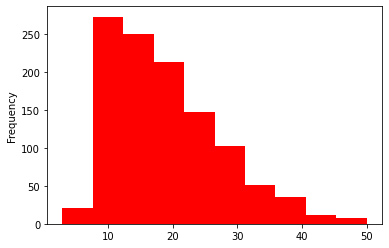

In [116]:
scotch['age'].plot.hist(color='red')

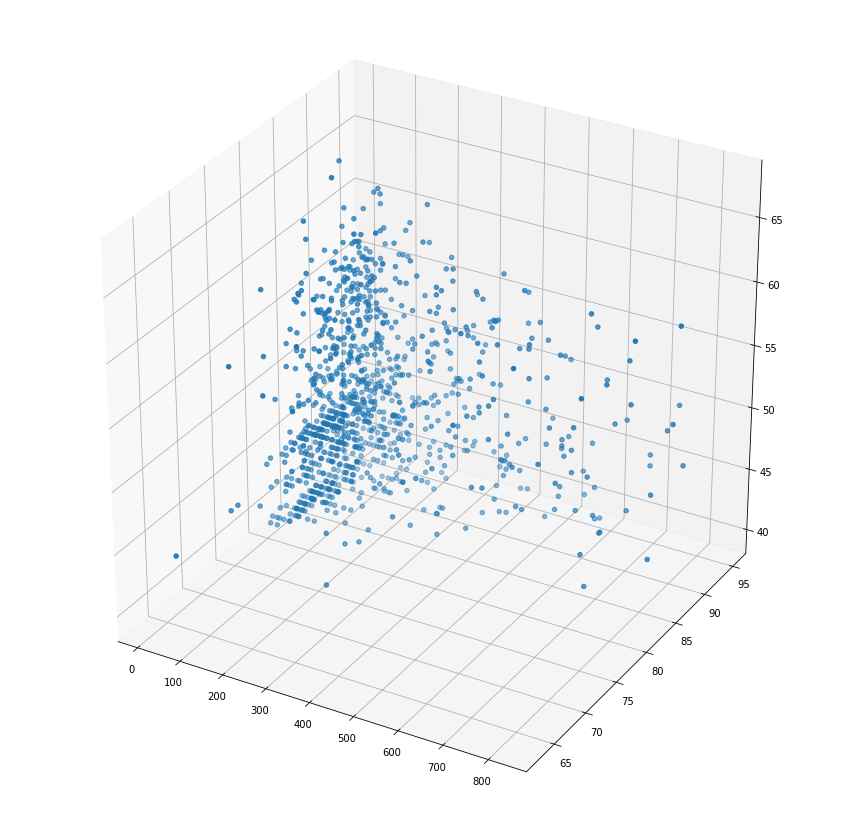

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['abv'])
plt.show()

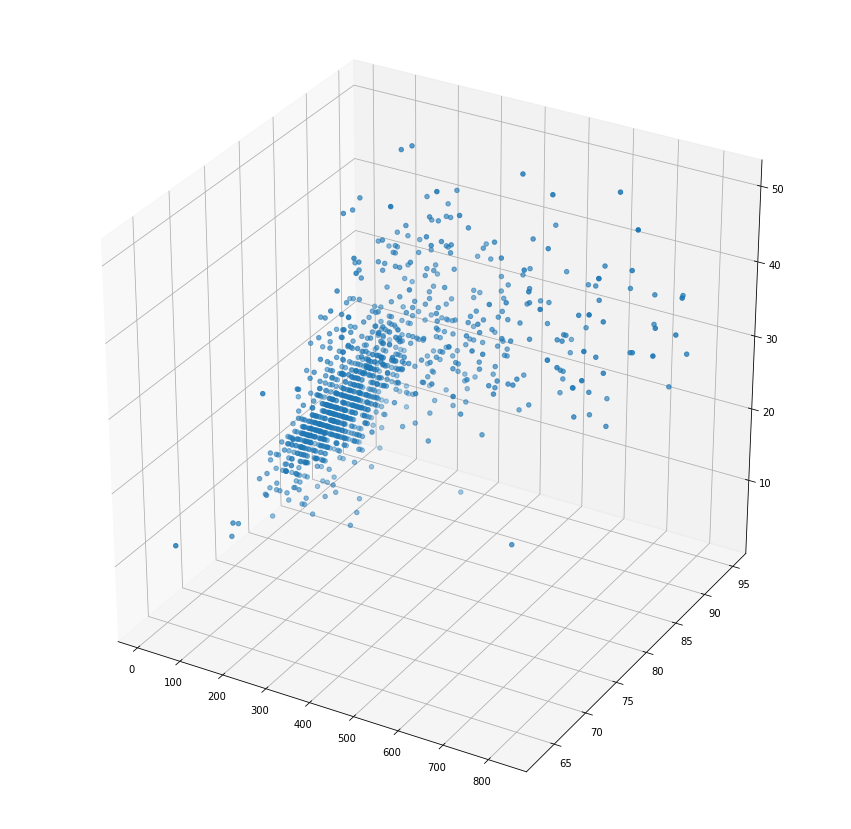

In [118]:
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'])
plt.show()

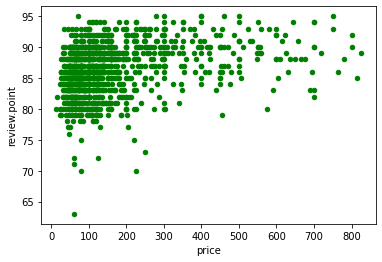

In [119]:
scotch.plot.scatter(x='price', y='review.point', color='green')

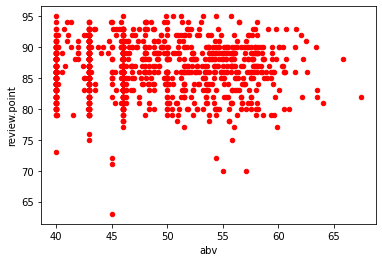

In [120]:
scotch.plot.scatter(x='abv', y='review.point', color='red')

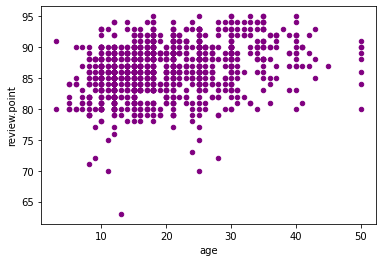

In [121]:
scotch.plot.scatter(x='age', y='review.point', color='purple')

Macierz korelacji

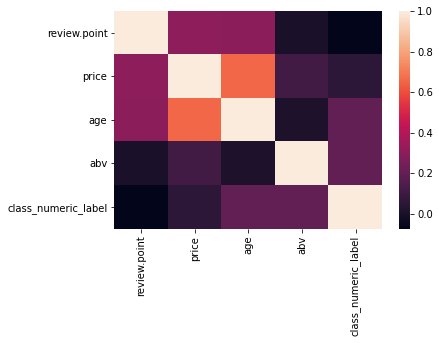

In [122]:
correlations = scotch_data.corr()

import seaborn as sns
sns.heatmap(correlations, 
        xticklabels=correlations.columns,
        yticklabels=correlations.columns)

## Klastrowanie

### K-Means Clustering

Kopia danych do przygotowania klastrowania

In [123]:

clustering_data = scotch_data[['age', 'price', 'review.point']].copy()
clustering_data.head(5)

,age,price,review.point
16,18.0,70.0,95
21,30.0,400.0,95
23,30.0,400.0,95
25,35.0,750.0,95
27,40.0,460.0,95


standaryzacja danych przy pomocy scalera (`StandardScaler`) z biblioteki `sklearn`, który odejmuje od każdej zmiennej średnią i dzieli ją przez odchylenie standardowe.

In [0]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# clustering_data[clustering_data.columns] = scaler.fit_transform(clustering_data)
# clustering_data.head(5)

2 klastry

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

inertia_scores = []
silhouette_scores = []
callinski_harabas = []
sample_clusters = np.arange(2, 12)
for n_clusters in sample_clusters:
  kmeans = KMeans(n_clusters=n_clusters).fit(clustering_data)
  inertia_scores.append(kmeans.inertia_)
  silhouette_scores.append(metrics.silhouette_score(clustering_data, kmeans.labels_))
  callinski_harabas.append(metrics.calinski_harabasz_score(clustering_data, kmeans.labels_))

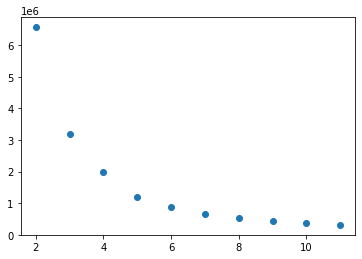

In [126]:
plt.scatter(x=sample_clusters, y=inertia_scores)

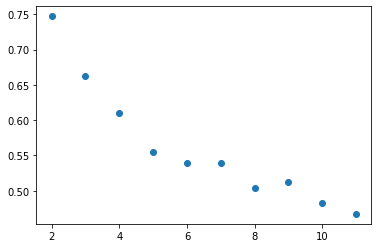

In [127]:
plt.scatter(x=sample_clusters, y=silhouette_scores)

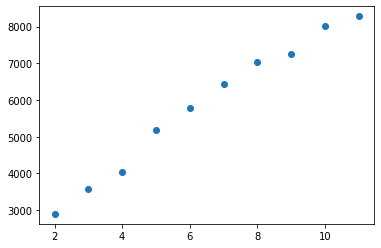

In [128]:
plt.scatter(x=sample_clusters, y=callinski_harabas)

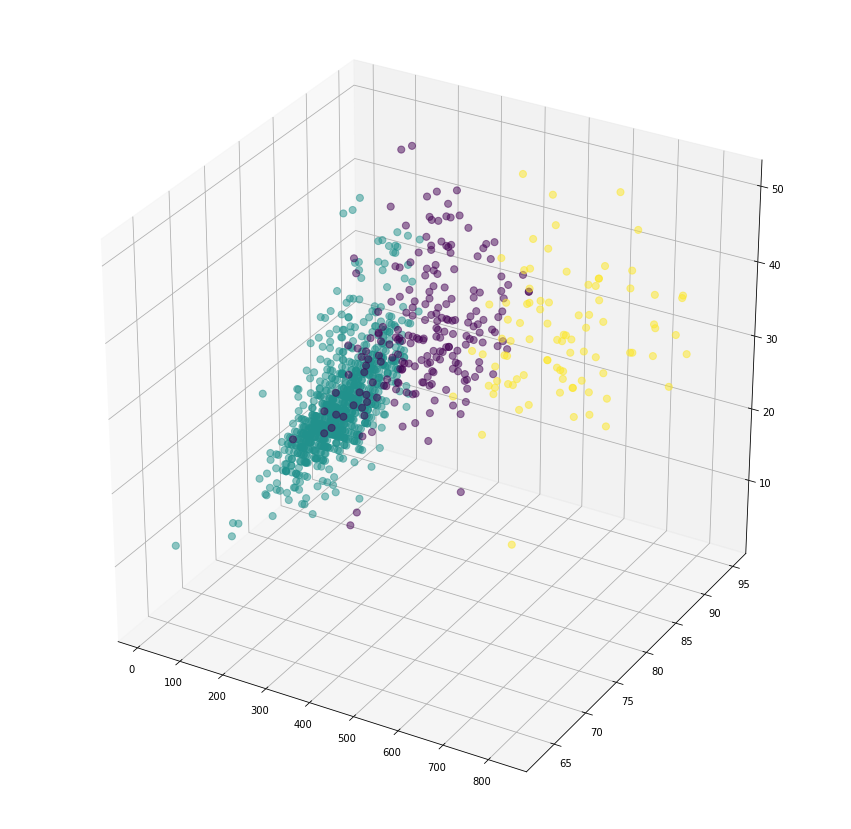

In [129]:
kmeans = KMeans(n_clusters=3).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.show()


## Agglomerative Clustering

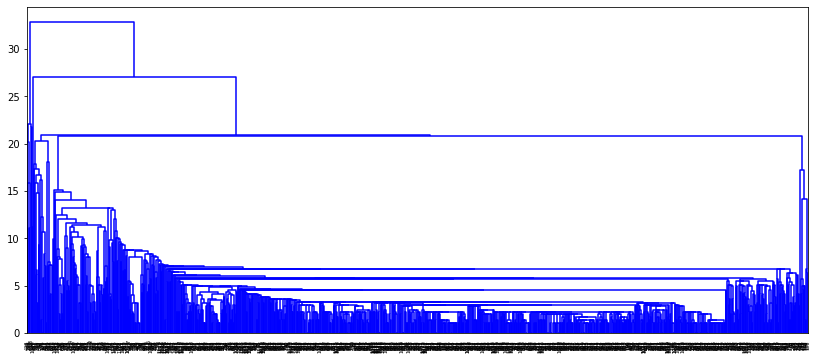

In [130]:
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

linkage_matrix=linkage(clustering_data,'single')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

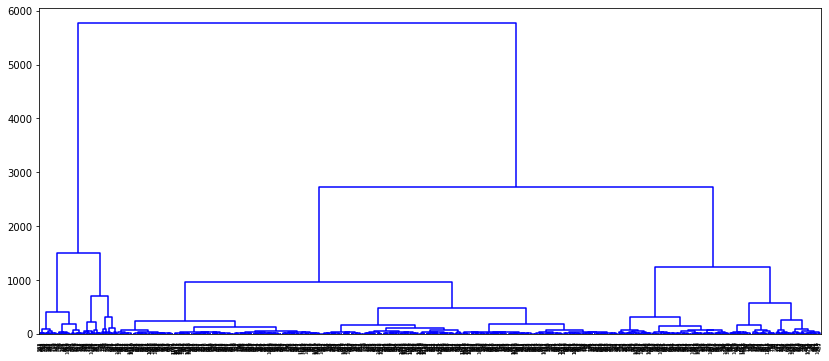

In [131]:
linkage_matrix=linkage(clustering_data,'ward')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

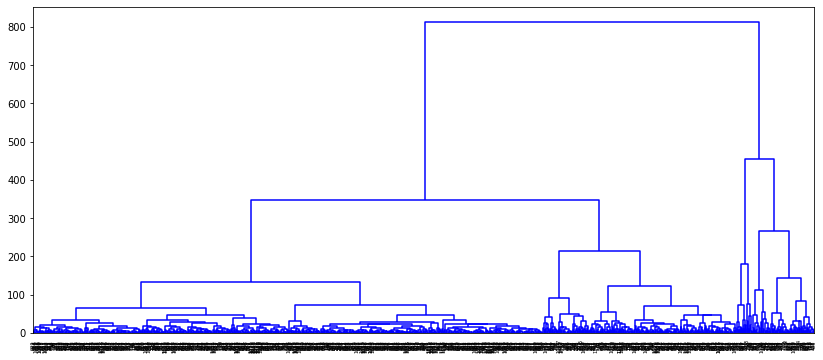

In [132]:
linkage_matrix=linkage(clustering_data,'complete')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

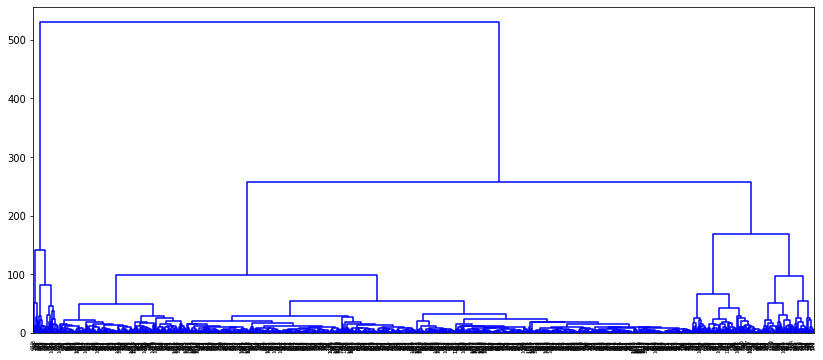

In [133]:
linkage_matrix=linkage(clustering_data,'average')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

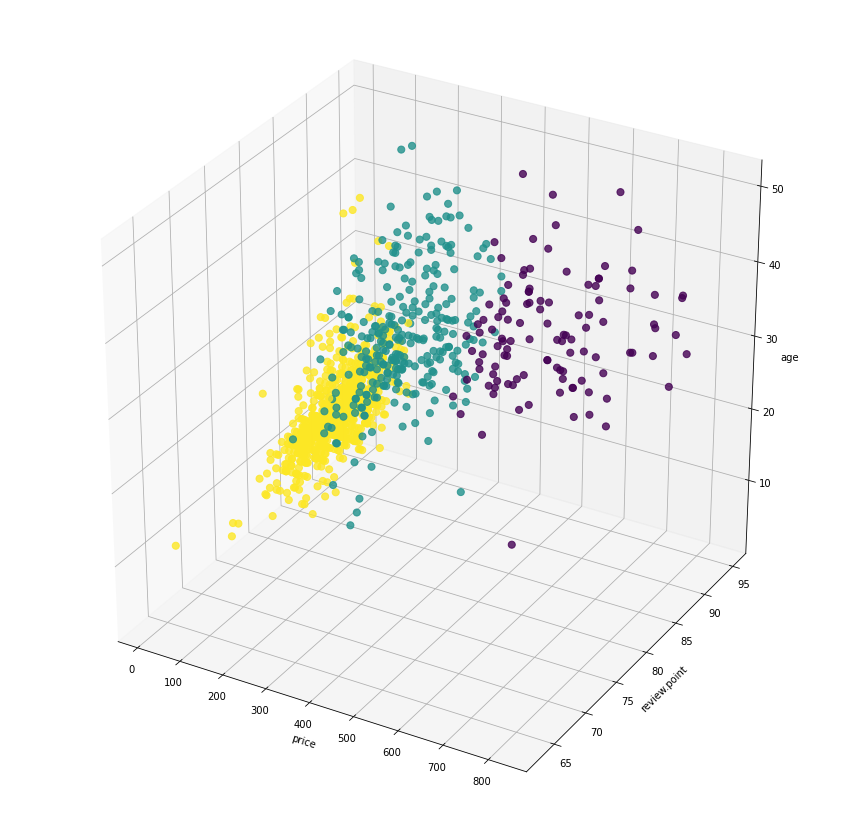

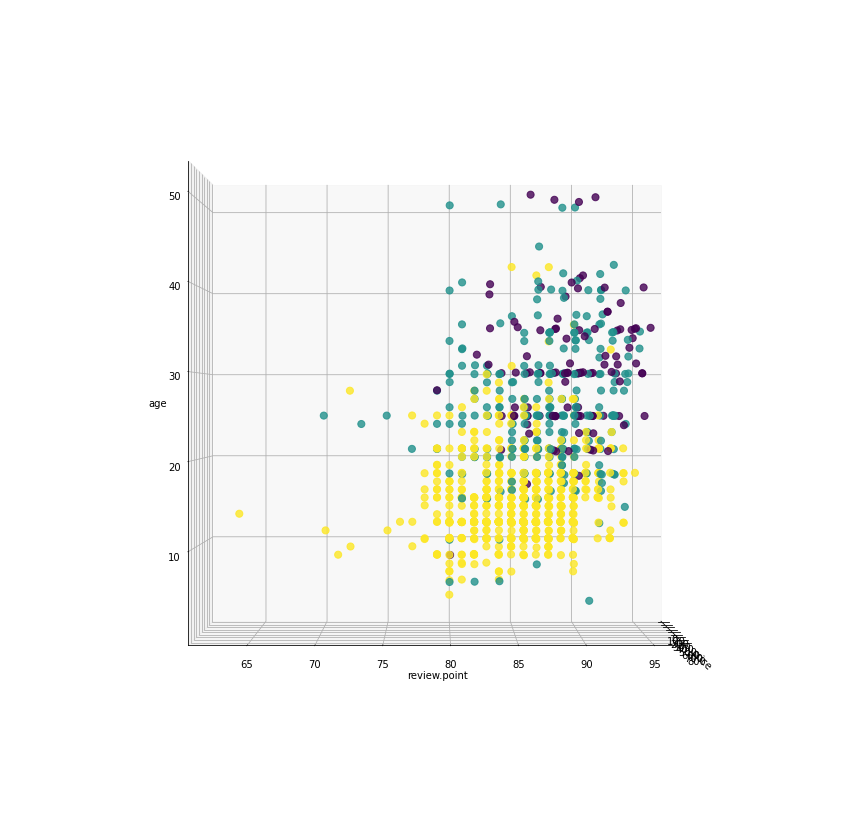

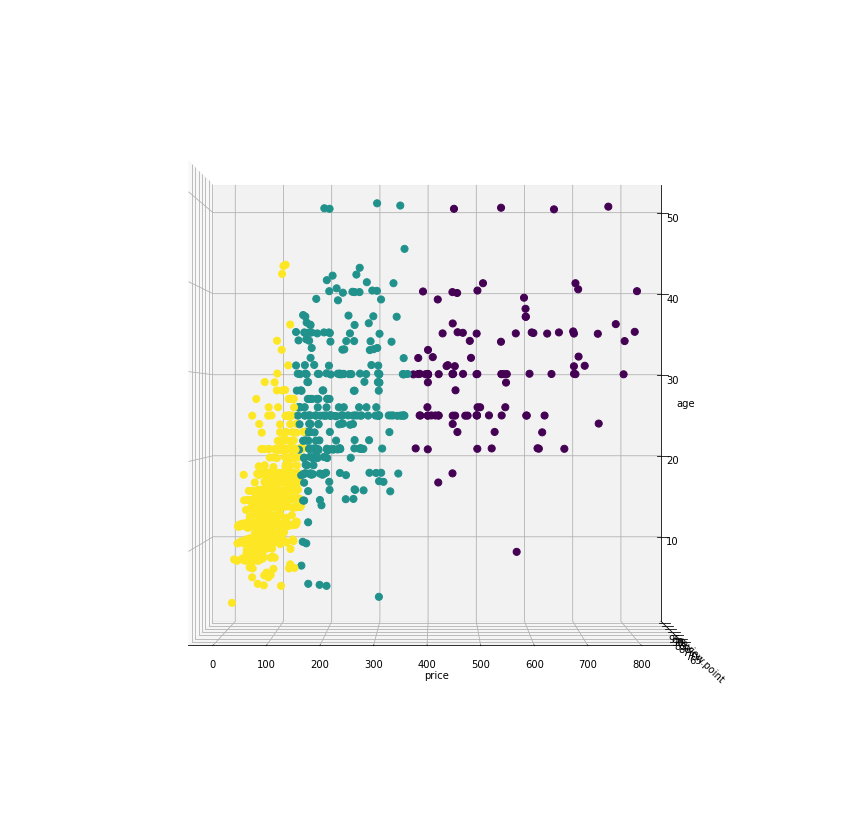

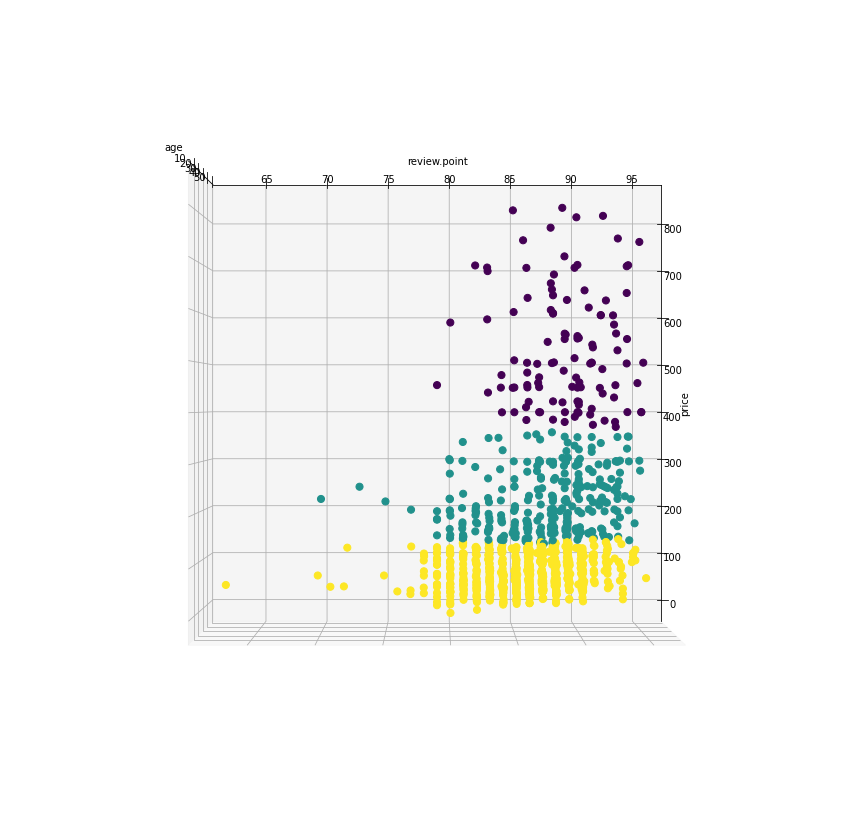

In [134]:

hc = AgglomerativeClustering(n_clusters=3).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
# threedee.view_init(15, -45)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=.8)

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')

threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(0, 00)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=.8)

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(0, -90)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=1)
plt.show()

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(-90, 0)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=1)
plt.show()

In [135]:
linkage_matrix=linkage(clustering_data,'ward')
class_number=fcluster(linkage_matrix,t=3,criterion='maxclust')
centers_new=clustering_data.groupby(class_number).mean()
centers_new_df=pd.DataFrame(centers_new)
centers_new_df.columns=clustering_data.columns
centers_new_df

,age,price,review.point
1,30.405405,529.819820,89.126126
2,15.005594,83.709091,85.538462
3,26.118056,217.722222,87.472222
